### 패키지 불러오기

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from preprocess import *

### 시각화 함수

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

### 학습 데이터 경로 정의

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

### 랜덤 시드 고정

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

### 파일 로드

In [5]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
print(len(index_inputs),  len(index_outputs), len(index_targets))

11823 11823 11823


### 모델 만들기에 필요한 값 선언

In [7]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

### 모델 

### 인코더

In [8]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim          
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))

### 어텐션

In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### 디코더

In [10]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim  
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
            
        x = self.fc(output)
        
        return x, state, attention_weights

In [11]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

### 시퀀스 투 스퀀스 모델

In [12]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx=2):    
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz) 
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz) 

    def call(self, x):
        inp, tar = x
        
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        predict_tokens = list()

        for t in range(0, tar.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) 
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))   
        
        return tf.stack(predict_tokens, axis=1)
    
    def inference(self, x):
        inp  = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([char2idx[std_index]], 1)
        
        predict_tokens = list()
        
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])
            
            if predict_token == self.end_token_idx:
                break
            
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)   
            
        return tf.stack(predict_tokens, axis=0).numpy()

In [13]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])
#model.run_eagerly = True

### 학습 진행

In [14]:
PATH = DATA_OUT_PATH + MODEL_NAME

if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))
        
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Train on 10640 samples, validate on 1183 samples
Epoch 1/30
10638/10640 [============================>.] - ETA: 0s - loss: 1.4387 - accuracy: 0.8092
Epoch 00001: val_accuracy improved from -inf to 0.81016, saving model to ./data_out/seq2seq_kor/weights.h5
10640/10640 [==============================] - 661s 62ms/sample - loss: 1.4387 - accuracy: 0.8092 - val_loss: 1.6265 - val_accuracy: 0.8102
Epoch 2/30
10638/10640 [============================>.] - ETA: 0s - loss: 1.2123 - accuracy: 0.8133
Epoch 00002: val_accuracy improved from 0.81016 to 0.81689, saving model to ./data_out/seq2seq_kor/weights.h5
10640/10640 [==============================] - 618s 58ms/sample - loss: 1.2122 - accuracy: 0.8133 - val_loss: 1.6311 - val_accuracy: 0.8169
Epoch 3/30
10638/10640 [============================>.] - ETA: 0s - loss: 1.0277 - accuracy: 0.8208
Epoch 00003: val_accuracy improved from 0.81689 to 0.82425, saving model to ./data_out/seq2seq_kor/weights.h5
10640/10640 [==============================]

10638/10640 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9398
Epoch 00024: val_accuracy improved from 0.93898 to 0.94048, saving model to ./data_out/seq2seq_kor/weights.h5
10640/10640 [==============================] - 616s 58ms/sample - loss: 0.0215 - accuracy: 0.9398 - val_loss: 2.9811 - val_accuracy: 0.9405
Epoch 25/30
10638/10640 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9412
Epoch 00025: val_accuracy improved from 0.94048 to 0.94189, saving model to ./data_out/seq2seq_kor/weights.h5
10640/10640 [==============================] - 617s 58ms/sample - loss: 0.0183 - accuracy: 0.9412 - val_loss: 3.0232 - val_accuracy: 0.9419
Epoch 26/30
10638/10640 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.9426
Epoch 00026: val_accuracy improved from 0.94189 to 0.94319, saving model to ./data_out/seq2seq_kor/weights.h5
10640/10640 [==============================] - 616s 58ms/sample - loss: 0.0192 - accuracy: 0.9426 -

### 결과 플롯

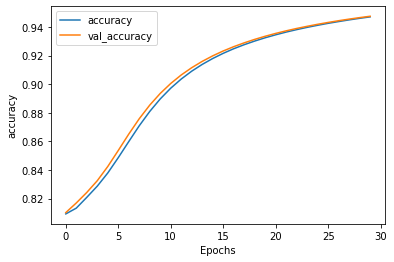

In [15]:
plot_graphs(history, 'accuracy')

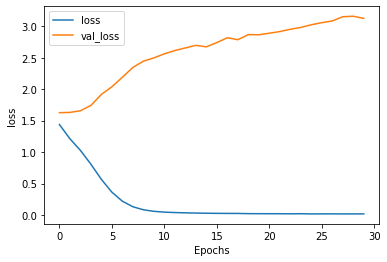

In [16]:
plot_graphs(history, 'loss')

### 결과 확인

In [17]:
SAVE_FILE_NM = "weights.h5"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [35]:
query = "남자친구 승진 선물로 뭐가 좋을까?"

test_index_inputs, _ = enc_processing([query], char2idx)    
predict_tokens = model.inference(test_index_inputs)

print(predict_tokens)
print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[1997]
부러워요
